# Select events from catalogue and save to individual file

_This version does not rely on the Basemap package_

In [1]:
%matplotlib notebook
from __future__ import print_function, division

In [2]:
import database
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import statsmodels.api as sm
from math import cos, asin, sqrt
import os
import pickle

from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.lines import Line2D

import cartopy.crs as ccrs
import cartopy.feature as feature
import shapely.geometry as sg


from netCDF4 import Dataset

from Utilities.config import ConfigParser
from Utilities.lmomentFit import samlmu, pelgev, pelgpa
from Utilities.track import ncReadTrackData

# Import widgets for interactive notebook
from ipywidgets import interact, fixed
import ipywidgets as widgets

from IPython.display import display

import seaborn as sns
sns.set_context("poster")
sns.set_style("whitegrid")

/home/547/cxa547/venv/notebooks/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
def makeSegments(xx, yy):
    points = np.array([xx, yy]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    return segments

def colorline(ax, xdata, ydata, zdata=None, alpha=0.9):
    colours=['0.75', '#0FABF6', '#0000FF', 
             '#00FF00', '#FF8100', '#ff0000']
    intervals = [0, 17.5, 24.5, 32.5, 44.2, 55.5, 1000]
    intervals = [800, 920, 935, 950, 970, 985, 1050]
    segments = makeSegments(xdata, ydata)
    cmap = ListedColormap(colours[::-1])
    norm = BoundaryNorm(intervals, cmap.N)
    lc = LineCollection(segments, array=zdata, cmap=cmap,
                        norm=norm, alpha=alpha)

    labels = ['No data', 'Category 1', 'Category 2',
              'Category 3', 'Category 4', 'Category 5']
    handles = []
    for c, l in zip(cmap.colors, labels[::-1]):
        handles.append(Line2D([0], [0], color=c, label=l))

    ax.add_collection(lc)
    ax.legend(handles, labels[::-1], loc=2, frameon=True, prop={'size': 10})

def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - np.cos((lat2-lat1)*p)/2 + np.cos(lat1*p)*np.cos(lat2*p) * (1-np.cos((lon2-lon1)*p)) / 2
    return 12742 * np.arcsin(np.sqrt(a))

def loadTrack(trackId):
    trackNum, trackYear = int(trackId.split('-')[0]), int(trackId.split('-')[1])
    trackFile = os.path.join(outputPath, 'tracks', 'tracks.{0:05d}.nc'.format(trackYear))
    tracks = ncReadTrackData(trackFile)
    
    return [t for t in tracks if t.trackId==(trackNum, trackYear)][0]

def getTracks(recs):
    tracks = []
    for rec in recs:
        trackId = rec['eventId']
        track = loadTrack(trackId)
        tracks.append(track)
    return tracks

def plot_tracks(gridLimit, tracks):
    '''
    Plot all of the tracks contained within the 'tracks' object
    '''
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(resolution='10m', color='black', linewidth=1)
    ax.add_feature(feature.BORDERS)
    gl = ax.gridlines(linestyle=":", draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    ax.set_xlim((gridLimit['xMin'], gridLimit['xMax']))
    ax.set_ylim((gridLimit['yMin'], gridLimit['yMax']))
    for track in tracks:
        colorline(ax, track.Longitude, track.Latitude, track.CentralPressure)
        ax.hold(True)
    return fig, ax


In [5]:
working_dir = '/g/data/w85/cek156/db10kyr/'
configFile = os.path.join(working_dir, 'tcrm2.0.ini')
configFile

'/g/data/w85/cek156/db10kyr/tcrm2.0.ini'

In [6]:
config = ConfigParser()
config.read(configFile)

db = database.HazardDatabase(configFile)
locations = db.getLocations()
locNameList = list(locations['locName'])
outputPath = config.get('Output', 'Path')
gridLimit = config.geteval('Region', 'gridLimit')

In [7]:
# Set up the thresholds for the different TC categories
TC_thresholds = {'category 3': 50, 'category 4': 60, 'category 5': 80}

#Set the distance threshold for locating TCs
dist_thr = 50

In [8]:
locations_to_analyse = {'Broome': [-17.952, 122.232], 'Port Hedland': [-20.310, 118.591], 
                        'Dampier/Karratha': [-20.704, 116.767], 'Exmouth': [-21.943, 114.134]}

name_list = []
for locs in locations_to_analyse:
    locsloc = locations_to_analyse[locs]
    listloc = [locations['locLat'], locations['locLon']]    
    temp_list = []
    for num in range(len(listloc[0])):
        temp_list.append(distance(locsloc[0], locsloc[1], listloc[0][num], listloc[1][num]))
    min_dist = temp_list.index(min(temp_list))
    name_list.append(locations[min_dist])

name_list

[(10720, u'Learmonth Airport', 114.08333, -22.23333),
 (10728, u'Port Hedland Bedout Island Aws', 119.1, -19.58333),
 (10671, u'Broome Airport', 122.21667, -17.95),
 (11188, u'Karratha Aerodrome Aws', 116.76667, -20.71667)]

Update the first index in this cell to set the location

In [9]:
events = database.locationRecords(db, str(name_list[3][0]))
locpt = sg.Point(name_list[3][2], name_list[3][3])
locationName = name_list[3][1]

Update the category here to select the category of events. We filter the complete list of records based on maximum wind speed recorded at the selected location

In [10]:
strength = 'category 5'
speed_thr = TC_thresholds[strength]

extreme_events = []
for event in events:
    if event['wspd'] > speed_thr:
        extreme_events.append(event)
        

In [11]:
tracks = getTracks(extreme_events)

tracks = [t for t in tracks if t.minimumDistance([locpt]) < dist_thr]
    
extremedf = pd.DataFrame.from_records(extreme_events, columns=events.dtype.names)
print("There are {0} events that pass within {1} km of {2}".format(len(tracks), dist_thr, locationName))

There are 3 events that pass within 50 km of Karratha Aerodrome Aws


<IPython.core.display.Javascript object>


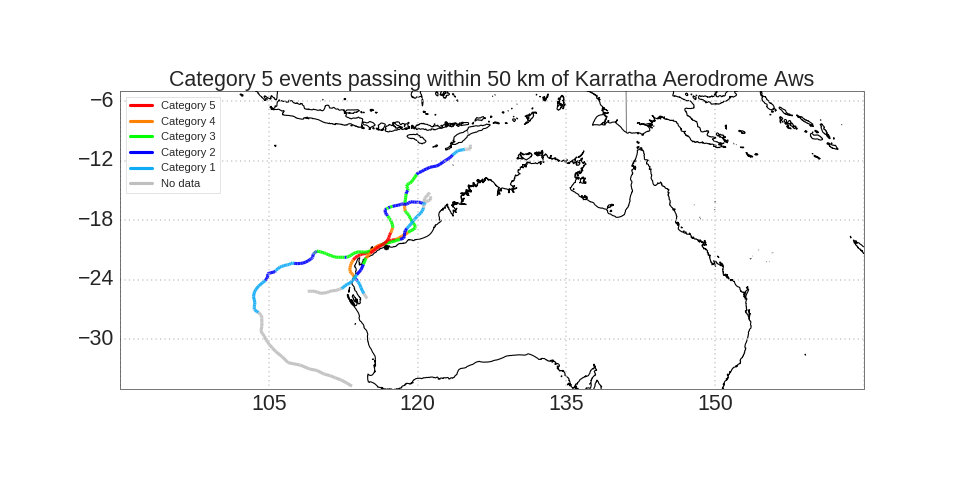

The installed widget Javascript is the wrong version.


In [12]:
fig, ax = plot_tracks(gridLimit, tracks)  
ax.scatter(locpt.x, locpt.y, color='k', s=20)
ax.set_title("{0} events passing within {1} km of {2}".format(strength.capitalize(),
                                                           dist_thr, locationName))
w = widgets.HTML("Click on the track you would like to identify")
def onclick(event):
    global Lon, Lat
    Lon, Lat = event.xdata, event.ydata
    w.value = 'Lon: {}, Lat: {}'.format(Lon, Lat) 
cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

In [13]:
Diffs = []
for track in tracks:

    min_val = min(abs(Lon - track.Longitude) + abs(Lat - track.Latitude))
    Diffs.append(min_val)
ix = Diffs.index(min(Diffs))
first, second = tracks[ix].trackId
first = str(first).zfill(3)
second = str(second).zfill(5)
eventid = '{0}-{1}'.format(first, second)

chosen = extremedf[extremedf['eventId'] == eventid]
chosen

,locId,locName,wspd,umax,vmax,eventId
5,11188,Karratha Aerodrome Aws,83.165031,-82.64502,-9.285622,009-07603


In [14]:
gust_filename = '{0}/windfield/gust.{1}.nc'.format(working_dir, str(chosen['eventId'].values[0]))
nc = Dataset(gust_filename)
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
vmax = nc.variables['vmax'][:][:]

trackYear = str(chosen['eventId'].values[0]).split('-')[1]
trackfile = '{0}/tracks/tracks.{1}.nc'.format(working_dir, trackYear)
eventTrack = getTracks(chosen.to_records())[0]


<IPython.core.display.Javascript object>


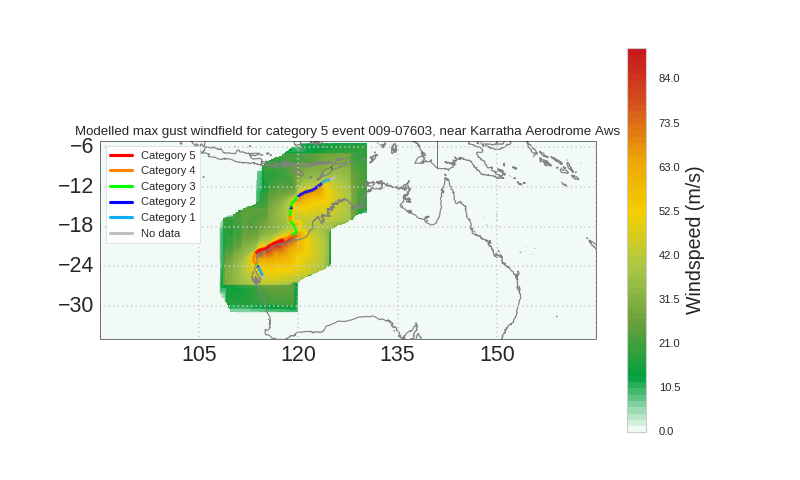

In [22]:
palette = [(1.000, 1.000, 1.000), (0.000, 0.627, 0.235), (0.412, 0.627, 0.235), (0.663, 0.780, 0.282),
        (0.957, 0.812, 0.000), (0.925, 0.643, 0.016), (0.835, 0.314, 0.118),
        (0.780, 0.086, 0.118)]
cmap = sns.blend_palette(palette, as_cmap=True)

fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='grey', linewidth=1)
ax.add_feature(feature.BORDERS)

colorline(ax, eventTrack.Longitude, eventTrack.Latitude, eventTrack.CentralPressure)
gl = ax.gridlines(linestyle=":", draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False

ax.set_xlim((gridLimit['xMin'], gridLimit['xMax']))
ax.set_ylim((gridLimit['yMin'], gridLimit['yMax']))
plt.contourf(lon, lat, vmax, 60, transform=ccrs.PlateCarree(), cmap = cmap)
plt.title('Modelled max gust windfield for {0} event {1}, near {2}'.format(strength, str(chosen['eventId'].values[0]), 
                                                                           str(chosen['locName'].values[0])), size=12)
ax.set_xlabel('Longitude', fontsize = 10)
ax.set_ylabel('Latitude', fontsize = 10)
cl = plt.colorbar(ax=ax, label="Windspeed (m/s)")
cl.ax.tick_params(labelsize=10)

plt.show()

In [16]:
from Utilities.track import ncSaveTracks

scenarioTrackFile = os.path.join(os.getcwd(), 'track.{0}.nc'.format(str(chosen['eventId'].values[0])))
print("Saving track data to {0}".format(scenarioTrackFile))
ncSaveTracks(scenarioTrackFile, [eventTrack], calendar='julian')

Saving track data to /home/547/cxa547/notebooks/tcrm/track.009-07603.nc
